In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [2]:
class World:
    def __init__(self, debug=False):                 # ここにロボットなどのオブジェクトを登録
        self.objects = []
        self.debug = debug
        
    def append(self, obj):              # オブジェクトを登録するための関数
        self.objects.append(obj)
        
    def draw(self):
        fig = plt.figure(figsize=(8, 8))     # 8*8 inchの図を準備
        ax = fig.add_subplot(111)            # サブプロットを準備
        ax.set_aspect('equal')               # 縦横比を座標の値と一致させる
        ax.set_xlim(-5, 5)                   # X軸を-5m * 5m の範囲で描画
        ax.set_ylim(-5, 5)                   # Y軸も同様に
        ax.set_xlabel("X", fontsize=20)      # X軸にラベルを表示
        ax.set_ylabel("Y", fontsize=20)      # 同じくY軸に
        
        elems = []
        
        if self.debug:
            for i in range(1000):
                self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=100, interval=1000, repeat=False)
            plt.show()
        
    def one_step(self, i, elems, ax):        # アニメーションを1コマ進める（ときに必要な処理）
        while elems:
            elems.pop().remove()
        elems.append(ax.text(-4.4, 4.5, "t = "+str(i), fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(1.0)

In [3]:
class IdealRobot:
    def __init__(self, pose, agent=None, color="black"):
        self.pose = pose               # 引数から姿勢の初期値を設定
        self.r = 0.2                   # これは描画のためなので固定値
        self.color = color             # 引数から描画するときの色を指定
        self.agent = agent             # エージェント
        self.poses = [pose]            # 軌跡の描画用
        
    def draw(self, ax, elems):
        x, y, theta = self.pose             # 姿勢の変数を分解して3つの変数へ
        xn = x + self.r * math.cos(theta)   # ロボットの鼻先のx座標
        yn = y + self.r * math.sin(theta)   # ロボットの鼻先のy座標
        
        elems += ax.plot([x, xn], [y, yn], color=self.color)    # ロボットの向きを表す線分の描画
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)   # ロボットの円を表すオブジェクト
        elems.append(ax.add_patch(c)) # 円を描画
        
        self.poses.append(self.pose) # 軌跡の描画　poses[]に姿勢を追加
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        
    
    @classmethod
    def state_transition(cls, nu, omega, time, pose):   # nuはvt
        t0 = pose[2]                   # θt-1
        if math.fabs(omega) < 1e-10:   # fabsは絶対値、角速度がほぼゼロの場合とそうでない場合で場合分け
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0), 
                                     omega] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time] )
        
    def one_step(self, time_interval):
        if not self.agent: return
        nu, omega = self.agent.decision()
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [4]:
class Agent:
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
    def decision(self, observation=None):
        return self.nu, self.omega

<IPython.core.display.Javascript object>


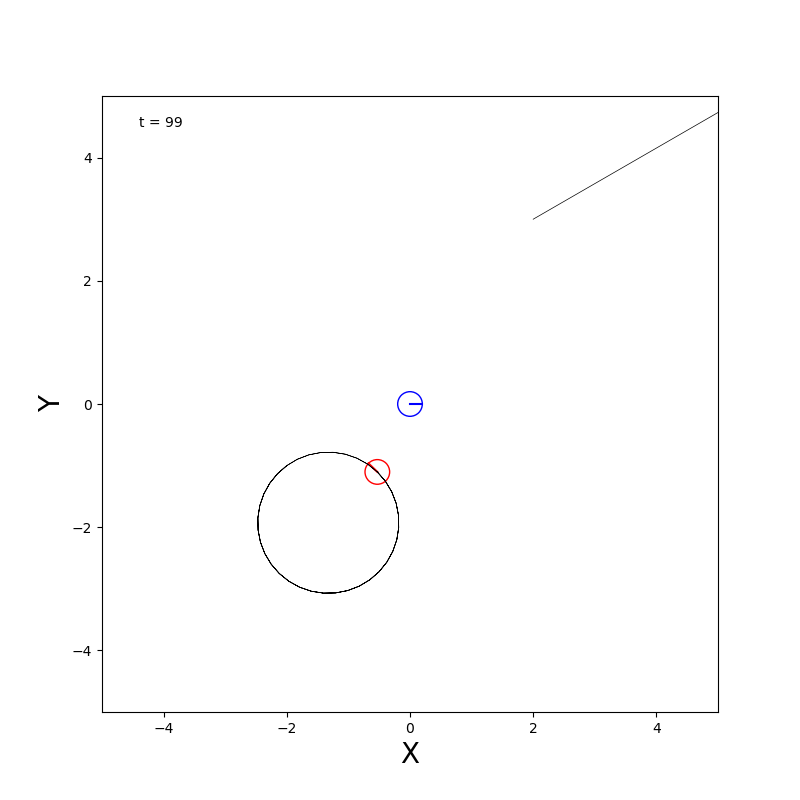

In [5]:
world = World()
straight = Agent(0.2, 0.0)                 # 0.2[m/s]で直進
circling = Agent(0.2, 10.0/180*math.pi)    # 0.2[m/s], 10[deg]で円を描く
robot1 = IdealRobot(np.array([2, 3, math.pi/6]).T, straight)
robot2 = IdealRobot(np.array([-2, -1, math.pi/5*6]).T, circling, "red")
robot3 = IdealRobot(np.array([0, 0, 0]).T, color="blue")  # エージェントを与えないロボット
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()

In [9]:
# 原点から0.1 m/sで 1 s 直進
IdealRobot.state_transition(0.1, 0.0, 1.0, np.array([0, 0, 0]).T)

array([0.1, 0. , 0. ])

In [10]:
# 原点から0.1[m/s], 10[deg/s]で9[s]移動
IdealRobot.state_transition(0.1, 10.0/180*math.pi, 9.0, np.array([0, 0, 0]).T)

array([0.5729578 , 0.5729578 , 1.57079633])

In [11]:
# 原点から0.1[m/s], 10[deg/s]で18[s]移動
IdealRobot.state_transition(0.1, 10.0/180*math.pi, 18.0, np.array([0, 0, 0]).T)

array([7.01670930e-17, 1.14591559e+00, 3.14159265e+00])